# ENGSCI762 Data Science Assignment

Develop a classifier for the California Housing dataset, which estimates the probability that the median house price of a specific district is larger or equal to USD500,000.

In [56]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## TASK 1 Define the label

-  Execute notebook `2_get_California_housing_data.ipynb` and download the California Housing dataset.
-  Write a function, which converts the continuous `median_house_value` into a class label, such that the label TRUE or 1 indicates a high priced district.
-  Amend the function `split_feature_labels()` (see below) from `4_prepare_California_housing.ipynb` by an optional parameter, which switches the output of the target from regression to classification  


In [57]:
def convert_median_house_value(housing):
    housing["median_house_value"] = housing["median_house_value"] >= 500000
    return housing

def split_features_labels(filename = '../data/train_set.csv', 
                          target_col='median_house_value',
                          classify=True):
    df = pd.read_csv(filename, index_col=0)
    
    if classify:
        df = convert_median_house_value(df)
        
    X = df.drop(target_col, axis=1)
    y = df[target_col].copy()
    return X, y

housing, housing_labels = split_features_labels(classify=True)
housing_test, housing_test_labels = split_features_labels('../data/test_set.csv', classify=True)

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-119.571981,35.634687,28.667696,2637.814801,538.206804,1426.546875,499.568314,3.867417
std,2.006763,2.138614,12.582749,2178.859507,420.659688,1141.436888,380.887558,1.903056
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1453.000000,296.000000,786.000000,280.000000,2.560300
50%,-118.490000,34.250000,29.000000,2127.000000,435.000000,1167.000000,410.000000,3.534800
75%,-118.007500,37.720000,37.000000,3150.000000,647.250000,1728.250000,606.000000,4.739600
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


## TASK 2: Exploratory analysis

- If you randomly choose a feature vector from your training set: What is the probability that this feature vector describes a high priced district with `median_house_value`>= USD500,000.
- Develop a function `conddist`, which visualizes the conditional distribution of a specific features with respect to the class labels. (Tip: consider seaborn.distplot) 
- Visualize the spatial distribution of the high-priced districts only (ignoring the other districts).

In [58]:
housing = pd.read_csv('../data/train_set.csv', index_col = 0)
housing = convert_median_house_value(housing)

sum(housing["median_house_value"])/housing['median_house_value'].count()

0.046875

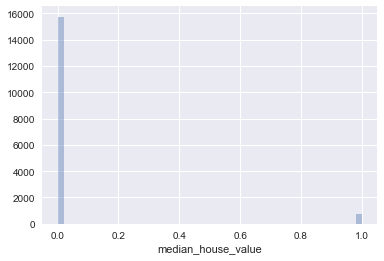

In [59]:
def conddist(feature):
    sns.distplot(feature, kde=False)
    
conddist(housing['median_house_value'])

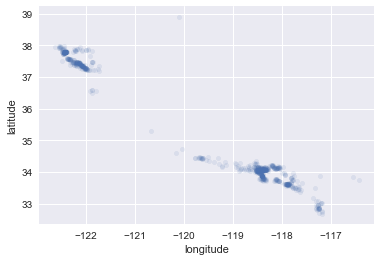

In [60]:
housing_copy = housing.copy()
housing_copy.where(housing_copy['median_house_value'], inplace=True)
housing_copy.dropna(subset=['median_house_value'], inplace=True)
housing_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

## TASK 3: Missing transformation

In notebook `3_explore_California_housing.ipynb` we had identified a useful transformation, which has not been implemented in `4_prepare_California_housing.ipynb`. 
* Amend the code of class `CombinedAttributesAdder` in order to include this transformation.
* Demonstrate that you're preparation pipeline has been successfully changed. 

### Temporarily remove categorical attribute

In [61]:
# Create DataFrame with numerical features
housing_num = housing.drop("ocean_proximity", axis=1)

In [62]:
import sklearn
sklearn.__version__

'0.18.1'

### Define pipelines

In [68]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class Binarizer(BaseEstimator, TransformerMixin):
    "Work around until CategoricalEncoder is in stable branch"
    def __init__(self):
        self.binarizer = LabelBinarizer()
    def fit(self, X, y=None):
        return self.binarizer.fit(X)
    def transform(self, X, y=None):
        return self.binarizer.transform(X)
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.added_columns = ["rooms_per_household", "population_per_household", "log_population_per_household"]
        if self.add_bedrooms_per_room:
            self.added_columns += ["bedrooms_per_room"]
            
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        log_population_per_househould = np.log(population_per_household)
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, log_population_per_househould, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household, log_population_per_househoul]
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Monkey-patch function returning feature names
all_num_columns = num_attribs + num_pipeline.named_steps['attribs_adder'].added_columns
num_pipeline.get_feature_names = lambda: all_num_columns

# Modify class by inheritance
cat_pipeline_steps = [
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_encoder', Binarizer()),
    ]

class MyPipeline(Pipeline):
    def get_feature_names(self):
        return self.steps[1][1].binarizer.classes_
    
cat_pipeline = MyPipeline(cat_pipeline_steps)

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

#obj = cat_pipeline.steps[1][1]
#obj.binarizer.classes_

#preparation_pipeline.get_feature_names()

In [69]:
X_train = pd.DataFrame(preparation_pipeline.fit_transform(housing),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing.index)
X_train.head()

,num_pipeline__longitude,num_pipeline__latitude,num_pipeline__housing_median_age,num_pipeline__total_rooms,num_pipeline__total_bedrooms,num_pipeline__population,num_pipeline__households,num_pipeline__median_income,num_pipeline__median_house_value,num_pipeline__rooms_per_household,num_pipeline__population_per_household,num_pipeline__log_population_per_household,num_pipeline__bedrooms_per_room,cat_pipeline__<1H OCEAN,cat_pipeline__INLAND,cat_pipeline__ISLAND,cat_pipeline__NEAR BAY,cat_pipeline__NEAR OCEAN
1862,-2.281365,2.887619,-0.927305,0.292908,0.217002,1.856885,0.224303,-0.830593,-0.221766,0.060497,0.255269,2.775788,-0.346868,0.0,0.0,0.0,0.0,1.0
18832,-1.668419,2.836182,-0.450447,0.633004,0.608756,0.181753,0.313571,-0.793651,-0.221766,0.402002,-0.039779,-0.265156,-0.260680,0.0,1.0,0.0,0.0,0.0
2488,-0.387710,0.236288,-1.563116,0.015231,0.262388,0.050336,0.108780,-1.135007,-0.221766,-0.193990,-0.030870,-0.124698,0.450124,0.0,1.0,0.0,0.0,0.0
7637,0.638850,-0.848560,-0.609400,0.800987,0.869129,1.106054,1.085476,-0.225916,-0.221766,-0.246395,-0.013438,0.135438,-0.128123,1.0,0.0,0.0,0.0,0.0
6941,0.733532,-0.769067,0.185363,-0.767771,-0.764773,-0.725026,-0.770771,-0.602847,-0.221766,-0.291004,-0.016668,0.088602,0.176319,1.0,0.0,0.0,0.0,0.0


## TASK 4: Visualize new continuous features
* Use function `conddist` from Task 2 for visualizing the new continuous features.
* Discuss the diagrams

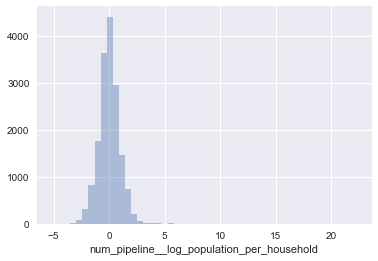

In [73]:
#conddist(X_train['num_pipeline__population_per_household'])
conddist(X_train['num_pipeline__log_population_per_household'])

## TASK 5: Use clustering for the engineering of additional geo-spatial features

- Read the documentation of `sklearn.clustering.KMeans` and train a `KMeans`model with respect to `longitude` and `lattidue`.
- Visualize the predictions of KMeans.
- How do the predictions change for different values of parameter `n_clusters`? 

## TASK 6: Add the KMeans predictions to the preparation pipeline

* Develop an extended `preparation_pipeline`, which includes the geo-spatial information provided by `KMeans.fit_transform()`. 
* What is the interpretation of these features?

## TASK 7: Evaluate different classifiers and select two

* Evaluate the accuracy of `LogisticRegression`, `DecisionTreeClassifier`, `AdaBoostClassifier`, `GradientBoostingClassifier`, and `RandomForestClassifier` with 10-fold cross-validation. 

- Discuss the most important features for the two best performing classifiers. Are the geo-spatial features relevant?

- Select the best performing classifier for the next task.

## TASK 8: Fine-tune the hyper-parameters of the best classifiers from Task 7

* Select the two best performing classifiers from TASK 7 and fine-tune their hyper-parameters.

## TASK 9: Measure the performance of your model
    
* Evaluate your best model on the test set. 
* What is its accuracy? 
* Compare the result to the accuracy you would get from guessing.